## Applied Machine Learning Homework 3 Task 5

Peter Grantcharov (pdg2116), Po-Chieh Liu (pl2441)

**The overall goal is to predict whether a payment by a company to a medical doctor or facility was made as part of a research project or not.**

In [1]:
# import base packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Task 5 Feature Selections
1. Identify features that are important for your best model. Which features are most influential, and which features could be removed without decrease in performance? 
2. Does removing irrelevant features make your model better?

Based on task 4, we will use decision tree classifier in task 5.

### Import data

In [61]:
# Selected features
col  = ['Recipient_State',
        'Recipient_Country',
        'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID',
        'Total_Amount_of_Payment_USDollars', 
        'Date_of_Payment', 
        'Form_of_Payment_or_Transfer_of_Value',
        'Dispute_Status_for_Publication', 
        'Related_Product_Indicator',
        'Covered_or_Noncovered_Indicator_1',
        'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
        'Covered_or_Noncovered_Indicator_2',
        'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2',
        'Covered_or_Noncovered_Indicator_3',
        'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_3',
       ]

# import file 1 and 2
file1 = pd.read_csv('OP_DTL_GNRL_PGYR2017_P01182019.csv', usecols = col)
file2 = pd.read_csv('OP_DTL_RSRCH_PGYR2017_P01182019.csv', usecols = col)

# Labeling
file1['y'] = int(0)
file2['y'] = int(1)

# combine (vertical stack)
df = pd.concat([file1, file2], sort = False)

# free memory
del file1, file2, col

# convert to datatime type and reduce to month only
df['Date_of_Payment'] = pd.to_datetime(df.Date_of_Payment, format = "%m/%d/%Y")
df['Date_of_Payment'] = pd.DatetimeIndex(df['Date_of_Payment']).month


### Deal with missing data

In [62]:
# Labelling all missing states as "Unknown"
df.Recipient_State[df.Recipient_State.isnull()] = 'Unknown'

# Grouping all non-us countries and United States Minor Outlying Islands together
df.Recipient_Country[~(
    (df.Recipient_Country == 'United States') |  (df.Recipient_Country.isnull()))] = 'Other'

# assign missing country as unknown country
df.Recipient_Country[df.Recipient_Country.isnull()] = 'Unknown'

# Assign not applicable for missing value
df.Covered_or_Noncovered_Indicator_1[df.Covered_or_Noncovered_Indicator_1.isnull()] = 'M1'
df.Covered_or_Noncovered_Indicator_2[df.Covered_or_Noncovered_Indicator_2.isnull()] = 'M2'
df.Covered_or_Noncovered_Indicator_3[df.Covered_or_Noncovered_Indicator_3.isnull()] = 'M3'

# if the Related_Product_Indicator indicator is Yes, then at least 1 item should be related
# so assume the missing of 1st indicator is missing
for i in range(1, 4):
    name = 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_' + str(i)
    df[name][( (df.Related_Product_Indicator == 'Yes') & (df[name].isnull()))] = 'Unknown' + str(i)

    # The missing indicator 1 with No of related indicator should be NA
    df[name][((df.Related_Product_Indicator == 'No'))] = 'NA' + str(i)


### Sklearn

In [63]:
# import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

In [64]:
# metric we want to use
scoring = {'balanced_accuracy' : 'balanced_accuracy',
           'precision' : 'precision',
           'average_precision' : 'average_precision', 
           'recall' : 'recall',
           'f1' : 'f1'}

### Subset of data

In [10]:
# list 
col = [el for el in df.columns if (el != 'y') ]

rand = np.random.choice(df.index.values, int(len(df) * 0.01))
s_df = df.ix[rand]

# subset features
X = s_df.loc[:, col]
y = s_df.loc[:,'y']

# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state = 1, 
                                                    stratify = y, 
                                                    train_size = 0.75)

## Decision Tree Classifier

In [65]:
# columns need transformation
label_col = [x for x in X_train.columns if x != 'Total_Amount_of_Payment_USDollars']

# make a copy
X_train_labeled = X_train.copy()

# transform
for el in label_col:
    X_train_labeled[el] = LabelEncoder().fit_transform(X_train_labeled[el])

In [66]:
dtc = DecisionTreeClassifier(random_state = 0, 
                                          max_depth=8,
                                          max_leaf_nodes=38)
dtc.fit(X_train_labeled, y_train)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=38,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

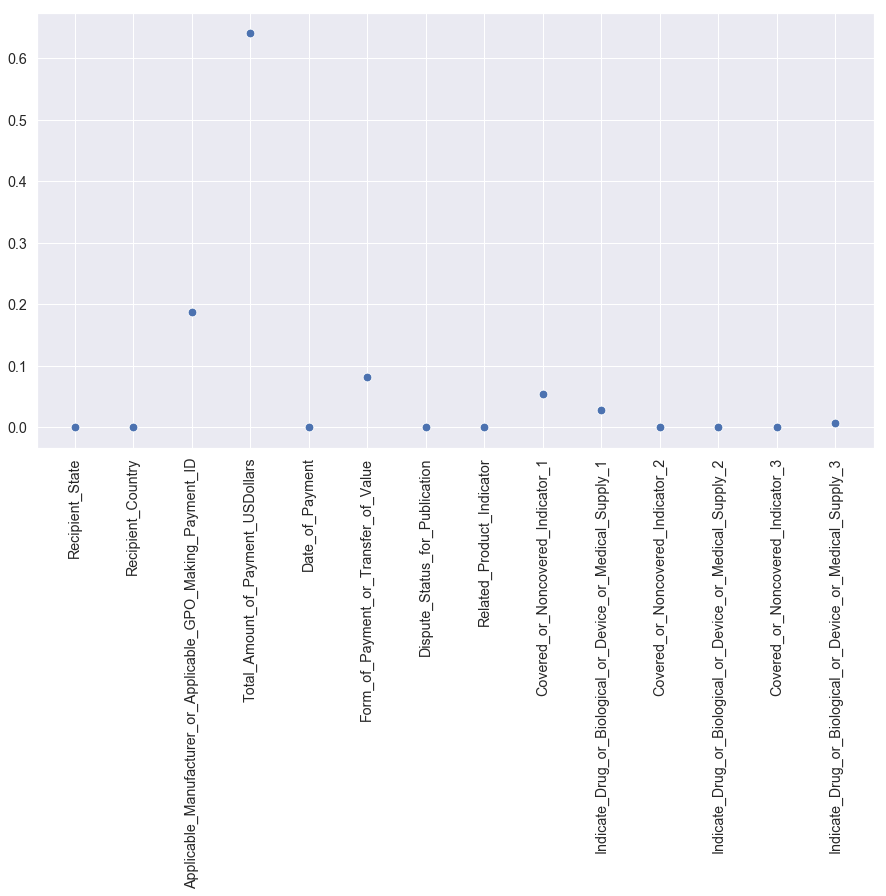

In [67]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot(x = range(1,len(X_train_labeled.columns)+1), 
                     y = dtc.feature_importances_, s = 75)
ax.set_xticks(range(1,len(X_train_labeled.columns)+1))
_ = ax.set_xticklabels(labels = X_train_labeled.columns, rotation=90)
sns.set(font_scale=1.5) 

### Select important features

From the above visualization, we could see that some features are much more important than others. We have decided to select the top four features, being:
1. Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID
2. Total_Amount_of_Payment_USDollars
3. Form_of_Payment_or_Transfer_of_Value
4. Covered_or_Noncovered_Indicator_1

In [68]:
selected_feature = ['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID',
                    'Total_Amount_of_Payment_USDollars',
                    'Form_of_Payment_or_Transfer_of_Value',
                    'Covered_or_Noncovered_Indicator_1']

In [69]:
X_train_subfeature = X_train_labeled.loc[:,selected_feature].copy()

In [74]:
# define param grid for grid search
param_grid1 = {'max_depth' : range(2, 30, 5)}
param_grid2 = {'max_leaf_nodes' : range(2, 102, 10)}

# grid searches
dt = DecisionTreeClassifier(random_state = 0)
grid1 = GridSearchCV(dt, param_grid = param_grid1, 
                    cv = 5, scoring = scoring,
                    refit = False)
grid2 = GridSearchCV(dt, param_grid = param_grid2, 
                    cv = 5, scoring = scoring,
                    refit = False)
# searching
_ = grid1.fit(X_train_subfeature, y_train)
_ = grid2.fit(X_train_subfeature, y_train)

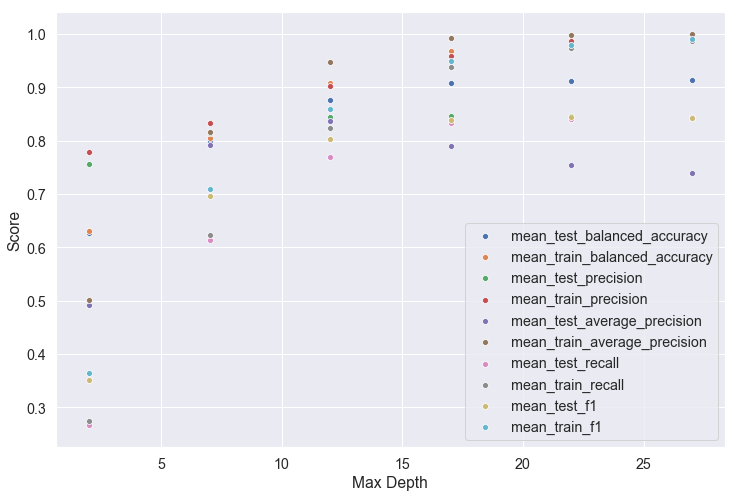

In [75]:
"""
Visualize the effect of max depth on scores
"""
plt.figure(figsize=(12,8))
for el in grid1.cv_results_.keys():
    if ('mean_test' in el) or ('mean_train' in el):
        sns.scatterplot(x = range(2, 30, 5), 
                        y= grid1.cv_results_[el], 
                        label = el)
sns.set(font_scale=1)
plt.xlabel("Max Depth")
plt.ylabel("Score")
plt.show()

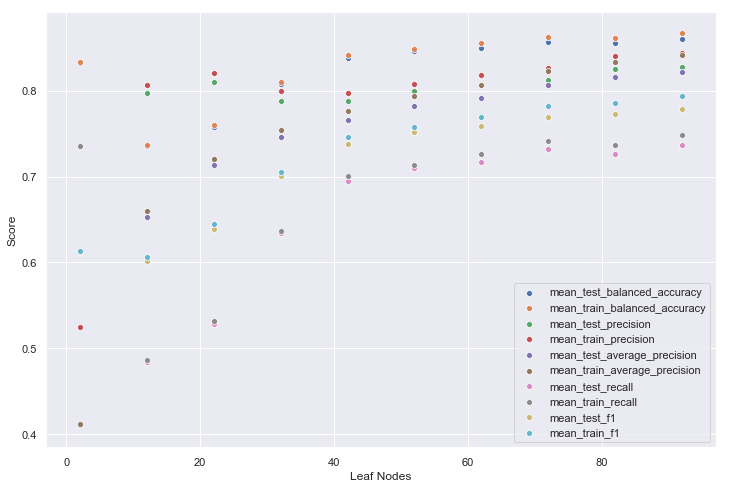

In [76]:
"""
Visualize the effect of leaf nodes on scores
"""
plt.figure(figsize=(12,8))
for el in grid2.cv_results_.keys():
    if ('mean_test' in el) or ('mean_train' in el):
        sns.scatterplot(x = range(2, 102, 10), 
                        y= grid2.cv_results_[el], 
                        label = el)
sns.set(font_scale=1.3)
plt.xlabel("Leaf Nodes")
plt.ylabel("Score")
plt.show()

Using only the four selected features, we performed the grid search for the new optimal hyperparameters, and produced the graphs above to visualize the results. The optimal max depth now appears to be around 17, afterwhich we see the test scores begin to deteriorate, while the number of leaf nodes seem to plateau at slightly greater of a value, at around 72.  

In [77]:
s = cross_validate(DecisionTreeClassifier(random_state = 0, 
                                          max_depth=17,
                                          max_leaf_nodes=72), 
                   X=X_train_labeled, y=y_train, scoring=scoring, cv=3)

score_list = ['test_balanced_accuracy', 'test_precision', 'test_average_precision', 'test_recall', 'test_f1']
for score in score_list:
    print("{s}: {v}".format(s=score, v=s[score].mean()))

test_balanced_accuracy: 0.8501422428312289
test_precision: 0.8316764080843247
test_average_precision: 0.8028762762128728
test_recall: 0.7157524443673902
test_f1: 0.7684288667916634


# Conclusion for Task 5

By doing the above feature selection, we saw that we can obtain similar test set scores with only 4 features rather than the originally select 9. It should be noted, however, that the decrease from scores of:

    test_balanced_accuracy: 0.9054942991245629
    test_precision: 0.87133171922319
    test_average_precision: 0.8861994127257433
    test_recall: 0.8238175815880368
    test_f1: 0.8467556494665823

... to scores of:

    test_balanced_accuracy: 0.8501422428312289
    test_precision: 0.8316764080843247
    test_average_precision: 0.8028762762128728
    test_recall: 0.7157524443673902
    test_f1: 0.7684288667916634
    
... is certainly not insignificant. The reduction in features required to still have decent performance, however, may be very beneficial in some contexts where data collection in expensive (computationally or otherwise). Therefore it would be impossible to make a definitive statement if this new reduced model is indeed "better," as we are observing the effects of the trade-off between model performance and convenience/time/resources. 
